<span style="color:grey"> By Seongchan Kang </span>

<span style="color:grey"> Version : Python 3.10.1 in Window </span>

# Text Summarize 실습

아마존 리뷰 데이터를 통해 긴 텍스트를 문장에서 요약하는 딥러닝 모델을 만들기

트랜스포머(어택션)를 활용하여 적용

데이터는 캐글에서 가져옴 (URL : <span> https://www.kaggle.com/snap/amazon-fine-food-reviews </span>)

그외 참고 사이트
 - <span> https://wikidocs.net/24996 </span>
 - <span> https://settlelib.tistory.com/56 </span>
 - <span> https://towardsdatascience.com/text-normalization-for-natural-language-processing-nlp-70a314bfa646 </span>
 - <span> https://glee1228.tistory.com/3 </span>


# 대략적인 과정

1. 텍스트 데이터 가져오기

2. 텍스트 데이터 전처리  

3. 딥러닝 모델 설계

4. 어택션 메커니즘 적용

5. 평가 및 적용

# Seq2Seq 와 어택션 메커니즘

기존 seq2seq은 디코더를 고정된 사이즈의 Context Vector로 받아 인코더로 변환하는 것

하지만 이 모델의 단점은 사이즈가 커지면 모든 정보를 담지 못한다는 것이 있음

어택션 메커니즘은 이 모델의 한계를 해결하기 위한 방안

그래서 어택션 메커니즘에 대해 간단히 말하면 각각의 입력되는 데이터에 가중치를 더하는 방법

집중해야할 단어에 대한 메커니즘에 대한 설계가 가능해짐

이런 전체적인 메커니즘을 가능하게 하기 위해 값이 잘못된 방향을 가고 있을 때 다시 정답으로 넣어 주는 과정이 필요 (Teacher Forcing이라고 함)

이것(Teacher Forcing)이 모델의 학습과 효율을 향상 시킴


## 데이터 가져오기

모든 데이터를 한번에 학습시키고 모델링하면 시간이 오랙 걸림

그래서 1000개의 데이터만 우선 뽑아서 실습

변수 설명
- 'Id' : 단순 넘버링을 위한 값
- 'ProductId' : 아마존에서 파는 제품의 번호
- 'UserId' : 암호화된 유저 아이디
- 'ProfileName' : 유저의 닉네임
- 'HelpfulnessNumerator' : 리뷰를 본 사람들 중에 이 리뷰가 유용하다고 한 사람의 수
- 'HelpfulnessDenominator' : 리뷰를 본 전체 사람의 수
- 'Score' : 리뷰어가 남긴 점수
- 'Time' : 리뷰어가 리뷰를 작성한 시점의 시간(Unix timestamp)(https://www.daleseo.com/python-time/)
- 'Summary' : "Text"변수를 요약한 것
- 'Text' : Reriews 본문

In [81]:
# 기본 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [40]:
review_df = pd.read_csv("Reviews.csv", nrows = 1000)
review_df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
995,996,B006F2NYI2,A1D3F6UI1RTXO0,Swopes,1,1,5,1331856000,Hot & Flavorful,BLACK MARKET HOT SAUCE IS WONDERFUL.... My hus...
996,997,B006F2NYI2,AF50D40Y85TV3,Mike A.,1,1,5,1328140800,Great Hot Sauce and people who run it!,"Man what can i say, this salsa is the bomb!! i..."
997,998,B006F2NYI2,A3G313KLWDG3PW,kefka82,1,1,5,1324252800,this sauce is the shiznit,this sauce is so good with just about anything...
998,999,B006F2NYI2,A3NIDDT7E7JIFW,V. B. Brookshaw,1,2,1,1336089600,Not Hot,Not hot at all. Like the other low star review...


In [41]:
review_df = review_df[['Text','Summary']]
review_df

,Text,Summary
0,I have bought several of the Vitality canned d...,Good Quality Dog Food
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised
2,This is a confection that has been around a fe...,"""Delight"" says it all"
3,If you are looking for the secret ingredient i...,Cough Medicine
4,Great taffy at a great price. There was a wid...,Great taffy
...,...,...
995,BLACK MARKET HOT SAUCE IS WONDERFUL.... My hus...,Hot & Flavorful
996,"Man what can i say, this salsa is the bomb!! i...",Great Hot Sauce and people who run it!
997,this sauce is so good with just about anything...,this sauce is the shiznit
998,Not hot at all. Like the other low star review...,Not Hot


## 텍스트 데이터 전처리

### 중복된 데이터 처리

In [42]:
# 중복 확인
review_df.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
995    False
996    False
997    False
998    False
999    False
Length: 1000, dtype: bool

In [43]:
# Text와 Summary 두 칼럼에서 중복되는 행중에 첫번째만 남겨두고 삭제
review_df = review_df.drop_duplicates(keep = 'first')
review_df

,Text,Summary
0,I have bought several of the Vitality canned d...,Good Quality Dog Food
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised
2,This is a confection that has been around a fe...,"""Delight"" says it all"
3,If you are looking for the secret ingredient i...,Cough Medicine
4,Great taffy at a great price. There was a wid...,Great taffy
...,...,...
995,BLACK MARKET HOT SAUCE IS WONDERFUL.... My hus...,Hot & Flavorful
996,"Man what can i say, this salsa is the bomb!! i...",Great Hot Sauce and people who run it!
997,this sauce is so good with just about anything...,this sauce is the shiznit
998,Not hot at all. Like the other low star review...,Not Hot


In [44]:
# 인덱스를 다시 정렬
review_df = review_df.reset_index(drop = True)
review_df

,Text,Summary
0,I have bought several of the Vitality canned d...,Good Quality Dog Food
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised
2,This is a confection that has been around a fe...,"""Delight"" says it all"
3,If you are looking for the secret ingredient i...,Cough Medicine
4,Great taffy at a great price. There was a wid...,Great taffy
...,...,...
992,BLACK MARKET HOT SAUCE IS WONDERFUL.... My hus...,Hot & Flavorful
993,"Man what can i say, this salsa is the bomb!! i...",Great Hot Sauce and people who run it!
994,this sauce is so good with just about anything...,this sauce is the shiznit
995,Not hot at all. Like the other low star review...,Not Hot


### 결측치 데이터 처리

In [45]:
# 결측치 확인
review_df.isnull().sum()

Text       0
Summary    0
dtype: int64

In [46]:
# 결측치 제거
review_df = review_df.dropna()
review_df

,Text,Summary
0,I have bought several of the Vitality canned d...,Good Quality Dog Food
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised
2,This is a confection that has been around a fe...,"""Delight"" says it all"
3,If you are looking for the secret ingredient i...,Cough Medicine
4,Great taffy at a great price. There was a wid...,Great taffy
...,...,...
992,BLACK MARKET HOT SAUCE IS WONDERFUL.... My hus...,Hot & Flavorful
993,"Man what can i say, this salsa is the bomb!! i...",Great Hot Sauce and people who run it!
994,this sauce is so good with just about anything...,this sauce is the shiznit
995,Not hot at all. Like the other low star review...,Not Hot


In [47]:
# 결측치 재확인
review_df.isnull().sum()

Text       0
Summary    0
dtype: int64

### 정제 및 정규화

1. 정제(cleaning): 불필요한 단어 또는 문자를 제거
2. 정규화(normalization): 같은 의미이면서 표현이 다른 단어를 통합
 - 규칙기반 정규화를 시키기엔 너무 많음 
 - 아래 참고 URL에 영어 규칙기반 정규화를 위한 딕셔너리가 있음
 - 참고 URL : <span> https://towardsdatascience.com/text-normalization-for-natural-language-processing-nlp-70a314bfa646 </span>

In [48]:
# 필요시 주석 지우고 다운로드
#%pip install nltk
#%pip install bs4
#%pip install autocorrect
#%pip install lxml

In [49]:
# 라이브러리 설치 및 불러오기
from nltk.corpus import stopwords 
from nltk.stem import SnowballStemmer
from bs4 import BeautifulSoup 
from autocorrect import Speller

import nltk
import re

In [50]:
# 불용어 
nltk.download('stopwords')
nltk.download("punkt")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\82108\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\82108\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [51]:
# 다운로드한 NLTK의 불용어
stop_words = set(stopwords.words('english'))
print('불용어 개수 :', len(stop_words))

불용어 개수 : 179


In [69]:
# 위에 있는 URL에서 가져옴
# 정규화를 위한 규칙 #
contractions_dict = {
  "ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have",
  "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
  "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", 
  "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", "I'd've": "I would have", 
  "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", 
  "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", 
  "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", 
  "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
  "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", 
  "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", 
  "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
  "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", 
  "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
  "so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", 
  "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is",
  "they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", 
  "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", 
  "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", 
  "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", 
  "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", 
  "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", 
  "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", 
  "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", 
  "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have", 
  "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", 
  "you've": "you have"
  }

## 키값 가져오기
contractions_re = re.compile('(%s)'%'|'.join(contractions_dict.keys()))
contractions_re # 확인용 1

re.compile(r"(ain't|aren't|can't|'cause|could've|couldn't|didn't|doesn't|don't|hadn't|hasn't|haven't|he'd|he'll|he's|how'd|how'd'y|how'll|how's|I'd|I'd've|I'll|I'll've|I'm|I've|i'd|i'd've|i'll|i'll've|i'm|i've|isn't|it'd|it'd've|it'll|it'll've|it's|let's|ma'am|mayn't|might've|mightn't|mightn't've|must've|mustn't|mustn't've|needn't|needn't've|o'clock|oughtn't|oughtn't've|shan't|sha'n't|shan't've|she'd|she'd've|she'll|she'll've|she's|should've|shouldn't|shouldn't've|so've|so's|this's|that'd|that'd've|that's|there'd|there'd've|there's|here's|they'd|they'd've|they'll|they'll've|they're|they've|to've|wasn't|we'd|we'd've|we'll|we'll've|we're|we've|weren't|what'll|what'll've|what're|what's|what've|when's|when've|where'd|where's|where've|who'll|who'll've|who's|who've|why's|why've|will've|won't|won't've|would've|wouldn't|wouldn't've|y'all|y'all'd|y'all'd've|y'all're|y'all've|you'd|you'd've|you'll|you'll've|you're|you've)",
           re.UNICODE)

In [70]:
# 확인용 2
document = "Hey, we aren't employees and we can't regist."

document = ' '.join([contractions_dict[t] if t in contractions_dict else t for t in document.split(" ")])

document

'Hey, we are not employee and we cannot regist.'

In [71]:
# 그냥 추가적으로 함수를 이용한 방법이라고 알고 있기

## 정규화를 위한 함수 ##
## 함수로 만들어서 사용하는게 오히려 하는데 시간이 오래걸림
def expand_contractions(s, contractions_dict = contractions_dict) :
    def replace(match) :
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, s)

## 토큰화 후 구두점 없애기 위한 함수 ##
## 구두점은 단순히 함부로 없애기엔 한계가 있기에 적절히 상화에 맞춰서 사용
def remove_punct(token):
    return [word for word in token if word.isalpha()]

In [74]:
# 위의 함수와 달리 이번 실습에서 직접 사용하는 코드 #
## 스펠링 맞춤법 ##
# https://www.delftstack.com/ko/howto/python/python-spell-checker/
spell = Speller(lang = "en")


# 전체 전처리 함수 #
## re.sub（검색 패턴, 치환되는 텍스트, 치환할려는 텍스트）
def preprocess_doc(document, remove_stopwords = True) :
    ## 소문자로 변환
    document = document.lower()

    ## 괄호 없애기
    document = BeautifulSoup(document, "lxml").text  # html 태그 제거 (<> ~~ <> 같은)
    document = re.sub(r'\([^)]*\)', ' ', document)   # 괄호로 묶인 문자열 제거 

    ## 정규화
    ## 띄어쓰기로 구분한 문장을 규칙 안에 있는거면 정규화 아니면 다시 똑같이 내보내기
    ## 딕셔너리로 되어있기 때문에 가능
    document = ' '.join([contractions_dict[t] if t in contractions_dict else t for t in document.split(" ")])   # 규칙기반 정규화    

    ## 필요없는 내용 제거 (스테밍)
    document = re.sub(r"'s\b","",document)           # 소유격 제거
    document = re.sub('"','', document)              # 큰따옴표 제거
    document = re.sub("'",'', document)              # 작은따옴표 제거
    document = re.sub("[^a-zA-Z]", " ", document)    # 영어 외 문자 공백치환

    ## 그외 전처리
    document = spell(document)                       # 철자 수정

    ## 불용어 처리 
    ## '구분자'.join(리스트)
    ## 문장을 구분하고 구분한 단어게 불용어가 아니고 공백이 아니면 join 불용어면 버리기
    if remove_stopwords :                            # 불용어 제거 (Text)
        tokens = ' '.join(word for word in document.split() if not word in stop_words if len(word) > 1)     
    ## Summary에서 불용어 처리를 하지않는 이유는 요약 방법이 "추상적 요약"이기 때문
    else :                                           # 불용어 미제거 (Summary)
        tokens = ' '.join(word for word in document.split() if len(word) > 1)
    return tokens

In [75]:
# Text 전처리 실행 #
all_text = []

## 텍스트 한문장씩 뽑아서 전처리후 all_text로 넣기
for s in review_df['Text']:
    all_text.append(preprocess_doc(s))

all_text[:5]
# 함수를 사용해서 처리했을 경우 약 1000개의 데이터는 4분 30초 정도 걸림
# 하지만 한줄로 코드를 만들어서 처리한 경우 같은 데이터의 갯수도 약 2분 50초정도 걸림

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unwanted sure error vendor intended represent product jumbo',
 'connection around centuries light pillow citrus relation nuts case filters cut tiny squares liberally coated powdered sugar tiny youthful heaven chew flavorful highly recommend dummy treat familiar story lewis lion witch wardrobe treat seduces demand selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great staff great price wide assortment dummy staff delivery quick staff lover deal']

In [76]:
# Summary 모음
all_summary = []

for s in review_df['Summary']:
    all_summary.append(preprocess_doc(s, 0))
    
all_summary[:5]

# 이건 약 30초

['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great staff']

In [77]:
# 다시 저장
review_df['Text'] = all_text
review_df['Summary'] = all_summary
review_df

,Text,Summary
0,bought several vitality canned dog food produc...,good quality dog food
1,product arrived labeled jumbo salted peanuts p...,not as advertised
2,connection around centuries light pillow citru...,delight says it all
3,looking secret ingredient robitussin believe f...,cough medicine
4,great staff great price wide assortment dummy ...,great staff
...,...,...
992,black market hot sauce wonderful husband loves...,hot flavorful
993,man say salsa bomb different kinds almost ever...,great hot sauce and people who run it
994,sauce good anything like adding asian food any...,this sauce is the shiznit
995,hot like low star reviewer got suffered seeing...,not hot


In [78]:
review_df.isnull().sum()

Text       0
Summary    0
dtype: int64

### 이상치 처리

In [79]:
# 길이 분포 출력 # 
## 문장 뽑아 구분한 뒤 길이만 출력하여 리스트로 저장
t_len = [len(t.split()) for t in review_df['Text']]
s_len = [len(s.split()) for s in review_df['Summary']]

print('Text 최소 길이 : {}'.format(np.min(t_len)))
print('Text 최대 길이 : {}'.format(np.max(t_len)))
print('Text 평균 길이 : {}'.format(np.mean(t_len)))
print('Summary 최소 길이 : {}'.format(np.min(s_len)))
print('Summary 최대 길이 : {}'.format(np.max(s_len)))
print('Summary 평균 길이 : {}'.format(np.mean(s_len)))

Text 최소 길이 : 5
Text 최대 길이 : 351
Text 평균 길이 : 35.01103309929789
Summary 최소 길이 : 0
Summary 최대 길이 : 22
Summary 평균 길이 : 3.982948846539619


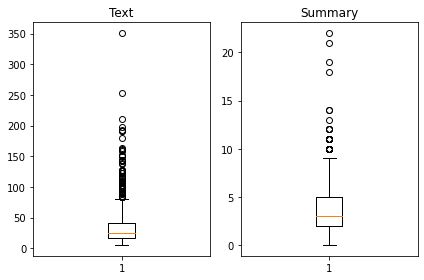

In [88]:
# Text boxplot
plt.subplot(1, 2, 1)
plt.boxplot(t_len)
plt.title('Text')

# Summary boxplot
plt.subplot(1, 2, 2)
plt.boxplot(s_len)
plt.title('Summary')

plt.tight_layout()
plt.show()

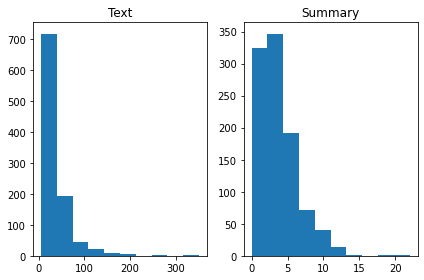

처리하기 전 데이터수 : 997


In [89]:
# Text를 한눈에 확인이 어려워서 다시 hist로 확인
# 보는김에 Summary도 같이 확인
plt.subplot(1, 2, 1)
plt.hist(t_len)
plt.title('Text')

plt.subplot(1, 2, 2)
plt.hist(s_len)
plt.title('Summary')

plt.tight_layout()
plt.show()

print('처리하기 전 데이터수 :',(len(review_df)))

In [92]:
# Boxplot 기준으로 이상치 제거 #

# Text #
review_df = review_df[review_df['Text'].apply(lambda x: len(x.split()) <= 100)]  # 100(최댓값에 근접한 숫자)을 기준으로 자르기
review_df = review_df[review_df['Text'].apply(lambda x: len(x.split()) >= 5)]    # 5(텍스트 최소값)을 기준으로 자르기

# Summary # 
review_df = review_df[review_df['Summary'].apply(lambda x: len(x.split()) <= 10)] # 10(최댓값에 근접한 숫자)을 기준으로 자르기
review_df = review_df[review_df['Summary'].apply(lambda x: len(x.split()) >= 1)]  # 1(서머리 0을 미리 제거함)을 기준으로 자르기

# 인덱스 다시 처리 후 확인 #
review_df = review_df.reset_index(drop = True)
review_df

,Text,Summary
0,bought several vitality canned dog food produc...,good quality dog food
1,product arrived labeled jumbo salted peanuts p...,not as advertised
2,connection around centuries light pillow citru...,delight says it all
3,looking secret ingredient robitussin believe f...,cough medicine
4,great staff great price wide assortment dummy ...,great staff
...,...,...
933,black market hot sauce wonderful husband loves...,hot flavorful
934,man say salsa bomb different kinds almost ever...,great hot sauce and people who run it
935,sauce good anything like adding asian food any...,this sauce is the shiznit
936,hot like low star reviewer got suffered seeing...,not hot


## 토큰화를 위한 작업

In [ ]:
#%pip install tensorflow

In [100]:
# 토큰화를 위한 라이브러리 불러오기
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

ModuleNotFoundError: No module named 'tensorflow'

In [95]:
# 데이터 타입 확인
review_df.dtypes

Text       object
Summary    object
dtype: object

In [96]:
# 데이터 타입 str으로 변환
review_df = review_df.astype('str')
review_df.dtypes

Text       object
Summary    object
dtype: object